In [3]:
import numpy as np

In [4]:
import sympy as sym
from math import *
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from scipy import optimize
import cvxopt
# from ipopt import minimize_ipopt

In /home/sashankmns/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sashankmns/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sashankmns/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/sashankmns/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sashankmns/.local/lib/python3.6/site-packages/m

In [5]:
# q1 = sym.Symbol('theta_1')
# q2 = sym.Symbol('theta_2')
# q3 = sym.Symbol('theta_3')
# q4 = sym.Symbol('theta_4')
m1 = 1
m2 = 1
l1 = 1
l2 = 1
lc1 = l1/2
lc2= l2/2
I1 = m1*l1**2/12
I2 = m2*l2**2/12
g=9.81


In [6]:
def cost_calc(Q,qddot,dt):
    global cost
    q1=Q[0,0]
    q2=Q[1,0]
    q3=Q[2,0]
    q4=Q[3,0]
    M_mat = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*cos(q2), I2 + m2*l1*lc2*cos(q2)],[I2 + m2*l1*lc2*cos(q2), I2]])
    C_mat = np.array([[-2*m2*l1*lc2*sin(q2)*q4, -m2*l1*lc2*sin(q2)*q4],[m2*l1*lc2*sin(q2)*q3, 0]])
    Tor_mat = np.array([[-m1*g*lc1*sin(q1) - m2*g*(l1*sin(q1) + lc2*sin(q1+q2))],[-m2*g*lc2*sin(q1+q2)]])
    U = (M_mat @ qddot).reshape(qddot.shape) + C_mat @ np.array([[q3],[q4]]) - Tor_mat
    return np.linalg.norm(U,axis=0)

In [7]:
def state_transition(Q,q1ddot,dt):
    global cost,t,tlast
    q1=Q[0,0]
    q2=Q[1,0]
    q3=Q[2,0]
    q4=Q[3,0]
    U = np.array([[0],[0]])
#     print(q1ddot.shape)
    M_mat = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*cos(q2), I2 + m2*l1*lc2*cos(q2)],[I2 + m2*l1*lc2*cos(q2), I2]])
    C_mat = np.array([[-2*m2*l1*lc2*sin(q2)*q4, -m2*l1*lc2*sin(q2)*q4],[m2*l1*lc2*sin(q2)*q3, 0]])
    Tor_mat = np.array([[-m1*g*lc1*sin(q1) - m2*g*(l1*sin(q1) + lc2*sin(q1+q2))],[-m2*g*lc2*sin(q1+q2)]])
    U = (M_mat @ q1ddot).reshape(q1ddot.shape) + C_mat @ Q[2:,0,None] - Tor_mat
#     print(U.shape)
    dot_mat = np.linalg.inv(M_mat) @ (Tor_mat + U - C_mat @ np.array([[q3],[q4]]))
    dot_mat.reshape(2,1)
    f = np.block([[q3],[q4],[dot_mat]])
    if t>tlast + 2:
        tlast=t
        print(round(t), end=' ')
    
    return Q + f*dt

In [8]:
def state_transition_func(Q,U):
    global cost,t,tlast
    q1=Q[0]
    q2=Q[1]
    q3=Q[2]
    q4=Q[3]
    U =U.reshape(2,1)
#     U = np.array([[0],[0]])
#     print(q1ddot.shape)
    M_mat = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*cos(q2), I2 + m2*l1*lc2*cos(q2)],[I2 + m2*l1*lc2*cos(q2), I2]])
    C_mat = np.array([[-2*m2*l1*lc2*sin(q2)*q4, -m2*l1*lc2*sin(q2)*q4],[m2*l1*lc2*sin(q2)*q3, 0]])
    Tor_mat = np.array([[-m1*g*lc1*sin(q1) - m2*g*(l1*sin(q1) + lc2*sin(q1+q2))],[-m2*g*lc2*sin(q1+q2)]])
#     U = (M_mat @ q1ddot).reshape(q1ddot.shape) + C_mat @ Q[2:,0,None] - Tor_mat
#     print(U.shape)
    dot_mat = np.linalg.inv(M_mat) @ (Tor_mat + U - C_mat @ np.array([[q3],[q4]]))
    dot_mat = dot_mat.flatten()
    f = np.array([q3,q4,dot_mat[0], dot_mat[1]])
    return f

In [9]:
import numpy as np
a=np.array([1,23,5,4,5,3,2,3])
b=np.where((a>=5) | (a<=2))[0]
# np.linalg.norm(a[b])
b
a[b+1]

array([23,  5,  4,  3,  3])

In [91]:
def obj_func(X):
    sum=0;
    global del_t
    i = np.arange(X.shape[0]);
    i = np.where((i < X.shape[0]-12) & ((i+1+7)%12==0))[0]
    sum = del_t/6.0*(np.linalg.norm(X[i])**2 + np.linalg.norm(X[i+1])**2 + 4*(np.linalg.norm(X[i+6])**2 + np.linalg.norm(X[i+1+6])**2) + np.linalg.norm(X[i+12])**2 + np.linalg.norm(X[i+1+12])**2)
#       if (i+1+7)%12==0:
#         sum=sum+del_t/6.0*(X[i]**2 + X[i+1]**2 + 4*(X[i+6]**2 + X[i+1+6]**2) + X[i+12]**2 + X[i+1+12]**2)
    return sum

In [168]:
def callback(xk,state):
    plt.plot([0,state.nit],[0,0],linewidth=4)
    plt.show(block=False)

In [11]:
# def interpol_constraints(Q,i,del_t):
#     boola
#     return boolarray.flatten()
# def collocation_constraints(Q,i,del_t):
#     boolarray = 
#     return boolarray.flatten()
arrr = np.array([(1,1)]*10)
arr2 = np.array([1]*6 + [0]*4)
# arrr[:,0] = arr2

a=inf
a
def wrap_angle(angle):
    while abs(angle) > np.pi:
        angle= angle-np.sign(angle)*2*np.pi
    return angle

In [163]:
del_t = 0.2
tf = 2;
q01 = pi/2
q02 = 0
qf1 = -pi/2
qf2 = 0
qdot1des = 1;
qdot2des = -1;

if qdot1des!=0:
    while np.sign(qf1-q01)!=np.sign(qdot1des):
        qf1 = qf1 + np.sign(qdot1des)*2*pi;
if qdot2des!=0:
    while np.sign(qf2-q02)!=np.sign(qdot2des):
        qf2 = qf2 + np.sign(qdot2des)*2*pi;
# q_init = np.block([[np.linspace(-pi/2,pi/2,tf/del_t)],[np.zeros((1,tf/del_t))],[],[]])
q0 = np.array([[q01],[q02],[0],[0]]);
qf = np.array([[qf1],[qf2],[0],[0]]);
Q0 = np.block([[q0[0,0] + (qf[0,0]-q0[0,0])*np.arange(0,tf+del_t/2,del_t/2)/(tf)],[q0[1,0] + (qf[1,0]-q0[1,0])*np.arange(0,tf+del_t/2,del_t/2)/(tf)],[q0[2,0] + (qf[2,0]-q0[2,0])*np.arange(0,tf+del_t/2,del_t/2)/(tf)],[q0[3,0] + (qf[3,0]-q0[3,0])*np.arange(0,tf+del_t/2,del_t/2)/(tf)],[0*np.arange(0,tf+del_t/2,del_t/2)],[0*np.arange(0,tf+del_t/2,del_t/2)]])
Q0 = Q0.T.flatten()

i = np.arange(Q0.shape[0]);
objind = np.where((i < Q0.shape[0]-12) & ((i+1+7)%12==0))[0]
objind2 = np.where((i-1 < Q0.shape[0]-12) & ((i-1+1+7)%12==0))[0]
objind3 = np.where((i-6 < Q0.shape[0]-12) & ((i-6+1+7)%12==0))[0]
objind4 = np.where((i-1-6 < Q0.shape[0]-12) & ((i-1-6+1+7)%12==0))[0]
objind5 = np.where((i-12 < Q0.shape[0]-12) & ((i-12+1+7)%12==0))[0]
objind6 = np.where((i-1-12 < Q0.shape[0]-12) & ((i-1-12+1+7)%12==0))[0]
hess_arr = np.zeros((Q0.shape[0],Q0.shape[0]))
hess_arr[objind,objind] = del_t/6.0
hess_arr[objind2,objind2] = del_t/6.0
hess_arr[objind3,objind3] = 4*del_t/6.0
hess_arr[objind4,objind4] = 4*del_t/6.0
hess_arr[objind5,objind5] = del_t/6.0
hess_arr[objind6,objind6] = del_t/6.0
Q0.shape
# np.arange(0,tf+del_t/2,del_t/2)
# Q=Q0
qf
# interpolarray = 0.5*(Q[a:a+4] + Q[a+12:a+12+4]) + del_t/8.0*(state_transition_func(Q[a:a+4],Q[a+4:a+6]) - state_transition_func(Q[a+12:a+12+4],Q[a+12+4:a+12+6])) - Q[a+6:a+6+4]
# interpolarray

array([[ 4.71238898],
       [-6.28318531],
       [ 0.        ],
       [ 0.        ]])

In [156]:
# bounds_array = np.array([(-inf,inf)]*Q0.shape[0])
equalityconstraints = [];
boundaryconstraints = [];
inputconstraints = [];
pathconstraints = [];
umin = -10000
umax = 10000
# bounds_array[0:4,0] = q0
# bounds_array[0:4,1] = q0
# bounds_array[-6:-2,0] = q0
# bounds_array[-6:-2,1] = qf
def bound_constraint(Q):
    return Q[-6] - qf[0,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[-5] - qf[1,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[-4] - qf[2,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[-3] - qf[3,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[0] - q0[0,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[1] - q0[1,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[2] - q0[2,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
def bound_constraint(Q):
    return Q[3] - q0[3,0]
boundaryconstraints.append({"type" : "eq" , "fun" : bound_constraint})
for i in range(Q0.shape[0]-11):
    if i%12==0:
        def input_constraint(Q,i=i):
            return np.linalg.norm(Q[i+4:i+6])-umin
        inputconstraints.append({"type" : "ineq" , "fun" : input_constraint})
        def input_constraint(Q,i=i):
            return -np.linalg.norm(Q[i+4:i+6])+umax
        inputconstraints.append({"type" : "ineq" , "fun" : input_constraint})
        def input_constraint(Q,i=i):
            return np.linalg.norm(Q[i+4+6:i+6+6])-umin
        inputconstraints.append({"type" : "ineq" , "fun" : input_constraint})
        def input_constraint(Q,i=i):
            return -np.linalg.norm(Q[i+4+6:i+6+6])+umax
        inputconstraints.append({"type" : "ineq" , "fun" : input_constraint})
#         def path_constraint(Q,i=i):
#             return Q[i+3]#*qdot2des
#         pathconstraints.append({"type" : "ineq" , "fun" : path_constraint})
#         def path_constraint(Q,i=i):
#             return Q[i+3+6]*qdot2des
#         pathconstraints.append({"type" : "eq" , "fun" : path_constraint})
#         def path_constraint(Q,i=i):
#             return Q[i+2]*qdot1des
#         pathconstraints.append({"type" : "ineq" , "fun" : path_constraint})
#         def path_constraint(Q,i=i):
#             return Q[i+2+6]*qdot1des
#         pathconstraints.append({"type" : "ineq" , "fun" : path_constraint})
        if i<Q0.shape[0]-17:
            for j in range(4):
                def interpol_constraint(Q,a=i,b=j):
                    global del_t
                    interpolarray = 0.5*(Q[a:a+4] + Q[a+12:a+12+4]) + del_t/8.0*(state_transition_func(Q[a:a+4],Q[a+4:a+6]) - state_transition_func(Q[a+12:a+12+4],Q[a+12+4:a+12+6])) - Q[a+6:a+6+4]
                    return interpolarray.flatten()[b]
                def collocation_constraint(Q,a=i,b=j):
                    global del_t
                    collocationarray = (Q[a:a+4] - Q[a+12:a+12+4]) + del_t/6.0*(state_transition_func(Q[a:a+4],Q[a+4:a+6]) + state_transition_func(Q[a+12:a+12+4],Q[a+12+4:a+12+6]) +4*state_transition_func(Q[a+6:a+6+4],Q[a+6+4:a+6+6]))
                    return collocationarray.flatten()[b]
                equalityconstraints.append({"type" : "eq" , "fun" : interpol_constraint});
                equalityconstraints.append({"type" : "eq" , "fun" : collocation_constraint});
        
constraints_array = boundaryconstraints+equalityconstraints+inputconstraints + pathconstraints
print(len(boundaryconstraints),len(inputconstraints),len(equalityconstraints),len(constraints_array))
print(len(boundaryconstraints + equalityconstraints))

8 40 80 128
88


In [164]:
opt_res = optimize.minimize(obj_func,Q0, jac = lambda x,mat=hess_arr : mat @ x, hess = lambda x : hess_arr,constraints=constraints_array,options={"maxiter" :10000})
Q_star =opt_res.x
# np.cos(Q_star)

/home/sashankmns/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method SLSQP does not use Hessian information (hess).
  RuntimeWarning)


True
Optimization terminated successfully
2570
control effort : 212.63824131195142
jacobian norm : 3.668390899615908
Max control input : (1.9047619047619047, 22.033500970029944)
[[  1.57079633   0.           0.           0.          15.25666786
   -7.51171615]
 [  1.42655699   0.60398915  -2.28863062   9.23592422   8.79130452
    5.61303046]
 [  1.23230142   1.27841308  -1.00032462   1.4086954   15.6551609
   -5.88304508]
 [  1.22367257   0.90550143   0.45656238  -6.89269873   5.23892827
    5.00248767]
 [  1.24937685   0.29471926  -0.31366208  -3.34871489   9.84115002
   -0.10096049]
 [  1.13241052   0.31067184  -1.39962975  -0.12375134   2.3256856
    3.08714466]
 [  1.09465784  -0.48833457   1.27061078 -19.64789464   2.20980442
   -0.49236642]
 [  1.6668591   -1.86791741   8.45428407  -8.06017371   1.72568373
   -7.1670273 ]
 [  2.44168858  -2.12365162   5.32317506   2.82907798   8.18843405
  -19.20047595]
 [  2.73432672  -2.60420254   1.74827483  -8.94166584   0.81965544
   -6.2047

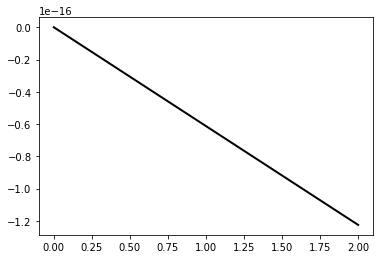

In [165]:
Q_sol = Q_star.reshape(round(Q_star.shape[0]/6),6)
print(opt_res.success)
print(opt_res.message)
print(opt_res.nit)
print("control effort : " + str(opt_res.fun))
print("jacobian norm : " + str(np.linalg.norm(opt_res.jac)))
inputs = np.linalg.norm(Q_sol[:,4:6],axis=1)
print("Max control input : " + str((np.argmax(inputs)/Q_sol.shape[0]*(tf),inputs.max())))
# np.linalg.norm(Q_sol[:,4:6])
print(Q_sol[:,:])
# Q_sol.shape
q =Q_sol[0,0:4].reshape(4,1)
plt.plot([0,l1*sin(q[0,0]),l1*sin(q[0,0])+l2*sin(q[1,0]+q[0,0])],[0,-l1*cos(q[0,0]),-l1*cos(q[0,0]) -l2*cos(q[1,0]+q[0,0])],'-k',linewidth=2)

In [169]:
def animate(i):
    global t, tf , q, u,del_t,l1,l2,Q_star,tlast,j
    if t[-1]<=tf+del_t/4 and j<=Q_sol.shape[0]:
        ax = plt.gca();
        ax.clear();
        q1ddot = 2*np.array([[-pi/2-q[0,0]],[0-q[1,0]]]) + 6*np.array([[-q[2,0]],[-q[3,0]]])
#         q = state_transition(q,q1ddot,0.01)
        q = Q_sol[j,0:4].reshape(4,1)
        if j == 0:
            q = Q_sol[0,0:4].reshape(4,1)
#         plt.clear()
        ax.plot([0,l1*sin(q[0,0]),l1*sin(q[0,0])+l2*sin(q[1,0]+q[0,0])],[0,-l1*cos(q[0,0]),-l1*cos(q[0,0]) -l2*cos(q[1,0]+q[0,0])],'-k',linewidth=2)
        ax.set_xlim([0-l1-l2,0+l1+l2])
        ax.set_ylim([0-l1-l2,0+l1+l2])
        if abs(t[-1]-0) < del_t/2:
            print(q.flatten(),j,t)
        t=np.append(t,t[-1]+del_t/2);
        j=j+1
        if abs(t[-1]-0) < del_t/2:
            print(q.flatten(),j,t)
        if t[-1]>=int(tlast)+2:
            tlast = int(t[-1])

[1.57079633 0.         0.         0.        ] 0 [0]


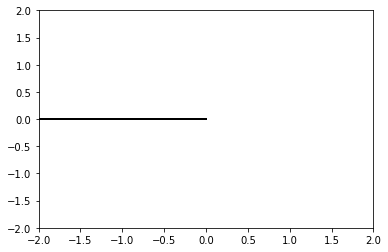

In [170]:
fig = plt.figure()
t=np.array([0]);
j=0
tlast=-2
q = np.zeros((4,1));
ani = animation.FuncAnimation(fig, animate, frames = Q_sol.shape[0], interval=del_t/2*1000)
HTML(ani.to_html5_video())
# print(t[-1])

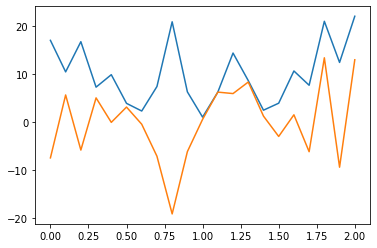

-1.3663706143591732

In [171]:
fig = plt.figure()
plt.plot(t[0:-1], np.linalg.norm(Q_sol[:,4:6],axis=1))
plt.plot(t[0:-1], Q_sol[:,5])
plt.show()
wrap_angle(11.2)

In [44]:
def obj_fun2(X):
    return np.sum(np.sin(X))

In [20]:
constraints2 = [];
def thisfun(X,b=0.4):
    return cos(X[0])-b
def constraint1(X):
    return cos(X[0]) - 0.1
constraints2.append({"type":"ineq","fun" : constraint1})
def constraint1(X):
    return cos(X[1]) - 0.2
constraints2.append({"type":"ineq","fun" : constraint1})
def constraint1(X):
    return thisfun(X)
constraints2.append({"type":"ineq","fun" : constraint1})

Q20 = np.pi,np.pi
#  jac = lambda x,mat=hess_arr : mat @ x ,
# constraints=boundaryconstraints+equalityconstraints+inputconstraints

In [ ]:
# ani = animation.FuncAnimation(fig, animate,frames = int((tf-t)/0.01), interval=20, blit=True)
# while t<tf:
# #     global t, tf , q, u
# #     ax=plt.gca()
# #     ax.clear()
# #     plt.clf()
#     u = 10*np.array([[-pi/2-q[0,0]],[0]])
#     q = state_transition(q,u,0.01)
#     t=t+0.01;
#     print("time is : %s "%(t))
# #         plt.clear()
# #     plt.show(block=False)
# #     time.sleep(0.2)
# plt.plot([0,l1*sin(q[0,0]),l1*sin(q[0,0])+l2*sin(q[1,0]+q[0,0])],[0,-l1*cos(q[0,0]),-l1*cos(q[0,0])-l2*cos(q[1,0]+q[0,0])],'-k',linewidth=2)
# plt.xlim([0-l1-l2,0+l1+l2])
# plt.ylim([0-l1-l2,0+l1+l2])
# plt.show()
print(q[0,0],t)
# fig2 = plt.figure()
# plt.plot([0,l1*sin(q[0,0]),l1*sin(q[0,0])+l2*sin(q[1,0]+q[0,0])],[0,-l1*cos(q[0,0]),-l1*cos(q[0,0])-l2*cos(q[1,0]+q[0,0])],'-k',linewidth=2)
# plt.xlim([0-l1-l2,0+l1+l2])
# plt.ylim([0-l1-l2,0+l1+l2])


In [159]:
t=0;
tf=100;
q1 = -pi/2
q3 = 0
while q1<pi/2:
    q=np.array([[q1],[0],[q3],[0]])
    qddot=np.block([[np.linspace(-I1*pi/2,I1*pi/2)],[np.zeros((1,50))]])
    cost_arr = cost_calc(q,qddot,0.01)
    q=np.array([[q1],[-2*q1],[q3],[-2*q3]])
    qddot[1,:] = -2*qddot[0,:]
    cost_arr2 = cost_calc(q,qddot,0.01)
    if not (cost_arr>=cost_arr2).all():
        break;
    q1 = q1+0.03
print(q1)
print(cost_arr>=cost_arr2)


-0.010796326794895394
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False]


SyntaxError: invalid syntax (<ipython-input-55-d9e35dbf27c6>, line 1)